In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

In [99]:
df_4th = pd.read_csv("C:/Users/jseidl/NFL-4th-Down/data/cleaned_4th_down.csv")

In [100]:
# Went or Stay
df_model = df_4th[df_4th["play_type"].isin(["run", "pass", "punt"])].copy()

# Converting to numeric
df_model["went_for_it"] = df_model["play_type"].isin(["run", "pass"]).astype(int)

In [101]:
# Feature Engineering

# Game Clock in seconds
df_model["game_seconds_remaining"] = (15 *60 * (4 - df_model["qtr"]))

features = df_model[[
    "ydstogo",
    "yardline_100",
    "score_differential",
    "game_seconds_remaining",
    "qtr",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining"
]].dropna()

labels = df_model.loc[features.index, "went_for_it"]


In [102]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [103]:
# Training the model

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

model = DecisionTreeClassifier(max_depth=4, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [104]:
joblib.dump(model, "tree_model.pkl")

['tree_model.pkl']

In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      8049
           1       0.86      0.68      0.76      1997

    accuracy                           0.91     10046
   macro avg       0.89      0.82      0.85     10046
weighted avg       0.91      0.91      0.91     10046



In [106]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

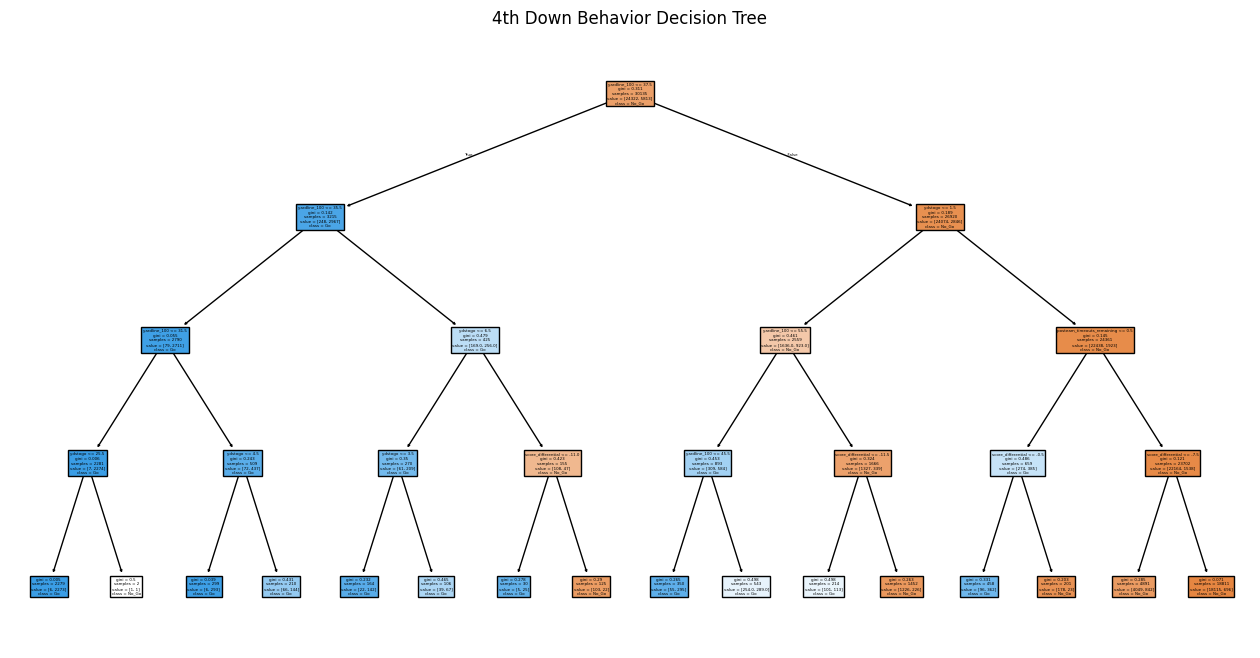

In [107]:
plt.figure(figsize=(16,8))
plot_tree(model, feature_names=features.columns, class_names=["No_Go", "Go"], filled=True)
plt.title("4th Down Behavior Decision Tree")
plt.show()

In [108]:
decision_table = pd.read_csv("C:/Users/jseidl/NFL-4th-Down/data/decision_table.csv")

In [109]:
from decision_logic import decide_ev_based

In [110]:
def parse_interval(interval_str):
    # Example: "(20, 30]" → pd.Interval(20, 30, closed='right')
    left_bracket = interval_str[0]
    right_bracket = interval_str[-1]
    left_closed = left_bracket == "["
    right_closed = right_bracket == "]"
    
    # Extract numbers
    bounds = ast.literal_eval(interval_str[1:-1])
    return pd.Interval(bounds[0], bounds[1], 
                       closed=('both' if left_closed and right_closed else 
                               'left' if left_closed else 
                               'right' if right_closed else 
                               'neither'))

# Reapply to both bin columns
decision_table["yard_bin"] = decision_table["yard_bin"].apply(parse_interval)
decision_table["distance_bin"] = decision_table["distance_bin"].apply(parse_interval)


In [111]:
# Compare EV model to actual behavior
df_model["ev_decision"] = df_model.apply(
    lambda row: decide_ev_based(row["ydstogo"], row["yardline_100"], decision_table), axis=1
)

df_model["ev_go"] = (df_model["ev_decision"] == "Go").astype(int)

# Confusion matrix: EV model vs real decision
pd.crosstab(df_model["went_for_it"], df_model["ev_go"], 
            rownames=["Actual (Coach)"], colnames=["Model (EV)"])

Model (EV),0,1
Actual (Coach),,
0,24138,8233
1,3854,3956


In [112]:
# Import for model deployment
import joblib

joblib.dump(model, "C:/Users/jseidl/NFL-4th-Down/data/tree_model.pkl")

['C:/Users/jseidl/NFL-4th-Down/data/tree_model.pkl']

In [113]:
joblib.dump(features.columns.tolist(), "C:/Users/jseidl/NFL-4th-Down/data/model_features.pkl")

['C:/Users/jseidl/NFL-4th-Down/data/model_features.pkl']